In [1]:
from loadmodules import *
import numpy as np
import os
from skimage.feature import peak_local_max
from skimage import io, color

%matplotlib inline
rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({
    "text.usetex": False
})

# path = '/home/pdcg/SimsOutput/'
path = './'
# simulation_list = [directory for directory in os.listdir(path) if 'Au6_lvl4' in directory]
simulation_list = ['Au6_lvl4_cfea_scbase', 'Au6_lvl4_cfea_compressive']

In [2]:
simulation_list

['Au6_lvl4_cfea_scbase', 'Au6_lvl4_cfea_compressive']

In [3]:
def get_stellar_projection_with_clusters(s, age_clus = 0.993, projection='faceon'):
    boxsize = 0.05
    dist = np.max( np.abs( s.pos - s.center[None,:] ), axis=1 )
    numthreads = 8
    res = 1024
    xres = res
    yres = res

    proj = np.zeros( (2,xres,yres,3) )
    for i in range(2):
        if i==0:
            istars, = np.where( (s.type == 4) & (dist < 1.5*boxsize) & (s.data['age'] > 0.) )
        else:
            istars, = np.where( (s.type == 4) & (dist < 1.5*boxsize) & (s.data['age'] > age_clus) & (s.data['nclt'] > 0) )

        pos_orig = s.pos[istars].astype('f8')
        mass = s.data['mass'][istars].astype('f8')

        particle_oct_tree = makeTree( pos_orig )
        hsml = particle_oct_tree.calcHsmlMulti( pos_orig, pos_orig, mass, 48, numthreads=numthreads )
        hsml = np.minimum( hsml, 4. * boxsize / res )
        hsml = np.maximum( hsml, 1.001 * boxsize / res * 0.5 )

        rho = np.ones( np.size(mass) )

        datarange = np.array( [ [4003.36,800672.], [199.370,132913.], [133.698,200548.] ] ) # ranges for each colour channel to make nice images ;)
        fac = (512./res)**2 * (0.5 * boxsize / 0.025)**2 # Normalised pixel area
        datarange *= fac

        pos = np.zeros( (size(istars),3) )
        if projection == 'faceon':
            pos[:,0] = pos_orig[:,1]
            pos[:,1] = pos_orig[:,2]
            pos[:,2] = pos_orig[:,0]
        elif projection == 'edgeon':
            pos[:,0] = pos_orig[:,0]
            pos[:,1] = pos_orig[:,2]
            pos[:,2] = pos_orig[:,1]

        boxx = boxsize
        boxy = boxsize

        """Import requried C routines"""
        import calcGrid 

        boxz = max( boxx, boxy )

        for k in range(3):
            iband = [3,1,0][k]
            band = 10 ** ( -2.0 * s.data['gsph'][istars,iband] / 5.0 )

            grid = calcGrid.calcGrid( pos, hsml, band.astype('f8'), rho, rho, xres, yres, 256, boxx, boxy, boxz, 
                                    0., 0., 0., 1, 1, numthreads=numthreads )

            drange = datarange[k]
            grid = np.minimum( np.maximum( grid, drange[0] ), drange[1] )
            loggrid = np.log10( grid )
            logdrange = np.log10( drange )

            proj[i,:,:,k] = (loggrid - logdrange[0]) / (logdrange[1] - logdrange[0])

    gray = color.rgb2gray(proj[1])
    coordinates = peak_local_max(gray, min_distance=1)

    return proj[0], coordinates

In [14]:
labels = ['No Formation Constraint', 'Formation Constraint']
projections_faceon = []
clusters_faceon = []
projections_edgeon = []
clusters_edgeon = []

for sim_id in range(2):
    snap = 127
    outputdir = path+simulation_list[sim_id]+'/output/'
    """Load a subfind catalogue for a given snapshot"""
    sf = load_subfind( snap, dir=outputdir, hdf5=True, loadonly=['fpos', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )

    """Then load various attributes of star+wind particles from snapshot"""
    partType = 4
    attrstoload = ['pos', 'vel', 'mass', 'age', 'bpos', 'bvel', 'bdens', 'gima', 'gsph', 'id', 'pot', 'nclt']
    snapbase="snapshot_"
    snapdirbase="snapdir_"

    print("Loading simulation ", simulation_list[sim_id], ", snapshot", snap)
    s = gadget_readsnap( snap, snappath=outputdir, snapbase=snapbase, snapdirbase=snapdirbase, hdf5=True, loadonlytype=[4], loadonly=attrstoload, subfind=sf )

    """Set up halo/subhalo indices in the gadget_readsnap.data struct"""
    s.calc_sf_indizes( sf )
    """Then select main halo, centre and rotate."""
    s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )

    # a=0.993 is the scale factor corresponding to 100Myr lookback time
    # a=0.986 is the scale factor corresponding to 100Myr lookback time
    print('Lookback time: ', s.cosmology_get_lookback_time_from_a(0.9655, is_flat=True))
    age_clus = 0.9655

    proj, coord = get_stellar_projection_with_clusters(s, age_clus=age_clus, projection='faceon')
    projections_faceon.append(proj)
    clusters_faceon.append(coord)
    
    proj, coord = get_stellar_projection_with_clusters(s, age_clus=age_clus, projection='edgeon')
    projections_edgeon.append(proj)
    clusters_edgeon.append(coord)
    print("Done with simulation ", simulation_list[sim_id])

Loading simulation  Au6_lvl4_cfea_scbase , snapshot 127
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Lookback time:  0.5027304443295079
Done with simulation  Au6_lvl4_cfea_scbase
Loading simulation  Au6_lvl4_cfea_compressive , snapshot 127
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Lookback time:  0.5027304443295079
Done with simulation  Au6_lvl4_cfea_compressive


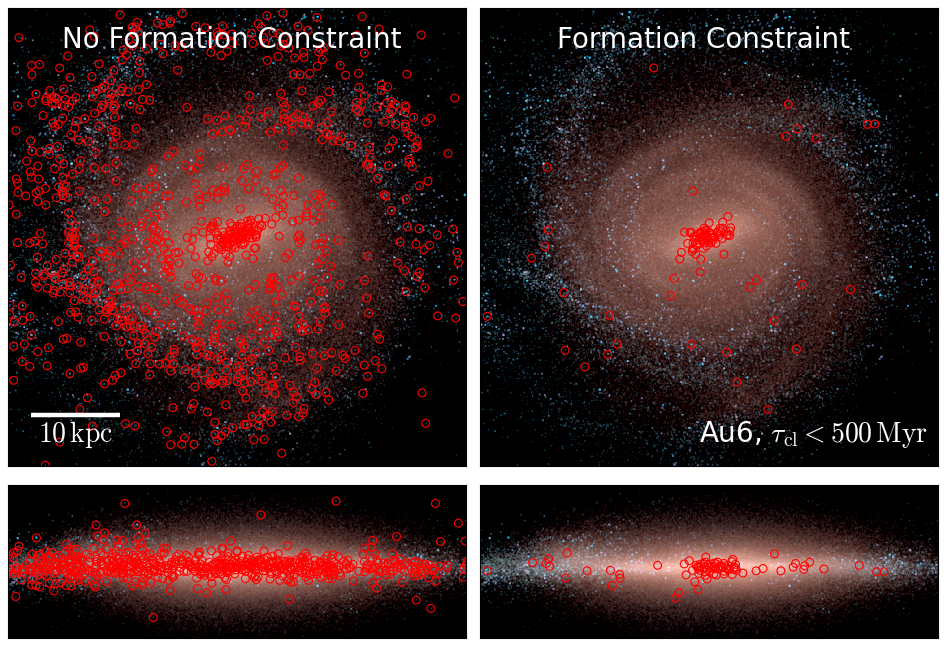

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10), gridspec_kw={'hspace': 0.03, 'wspace': 0.03, 'height_ratios': [3, 1]})

ax[0, 0].set_xticks( [] )
ax[0, 0].set_yticks( [] )
ax[0, 0].imshow(projections_faceon[0], interpolation='nearest' )
ax[0, 0].scatter(clusters_faceon[0][:,1], clusters_faceon[0][:,0], s=50, marker='o', edgecolors='r', facecolors='none')
ax[0, 0].text(500,90, labels[0], color='white', fontsize=25, ha='center')
ax[0, 0].hlines(910, 50, 250, colors='white', linewidth=4)
ax[0, 0].text(150, 970, r'$10 \, \rm{kpc}$', color='white', fontsize=25, ha='center')

# ax1 = axes( [0., 0., 1., 1.] )
ax[1, 0].set_xlim(0., 1000.)
ax[1, 0].set_ylim(1000. - (1000./3.), (1000./3.))
ax[1, 0].set_xticks( [] )
ax[1, 0].set_yticks( [] )
ax[1, 0].imshow(projections_edgeon[0], interpolation='nearest' )
ax[1, 0].scatter(clusters_edgeon[0][:,1], clusters_edgeon[0][:,0], s=50, marker='o', edgecolors='r', facecolors='none')

ax[0, 1].set_xticks( [] )
ax[0, 1].set_yticks( [] )
ax[0, 1].imshow(projections_faceon[1], interpolation='nearest' )
ax[0, 1].scatter(clusters_faceon[1][:,1], clusters_faceon[1][:,0], s=50, marker='o', edgecolors='r', facecolors='none')
ax[0, 1].text(500,90, labels[1], color='white', fontsize=25, ha='center')
ax[0, 1].text(490, 970, r'Au6, $\tau_{\rm{cl}} < 500 \, \rm{Myr}$', color='white', fontsize=25, ha='left')

# ax1 = axes( [0., 0., 1., 1.] )
ax[1, 1].set_xlim(0., 1000.)
ax[1, 1].set_ylim(1000. - (1000./3.), (1000./3.))
ax[1, 1].set_xticks( [] )
ax[1, 1].set_yticks( [] )
ax[1, 1].imshow(projections_edgeon[1], interpolation='nearest' )
ax[1, 1].scatter(clusters_edgeon[1][:,1], clusters_edgeon[1][:,0], s=50, marker='o', edgecolors='r', facecolors='none')

# plt.savefig('./plots/stellar_light_with_clusters_paper.pdf', bbox_inches='tight')

In [10]:
import pynbody
import numpy as np
import matplotlib.pyplot as plt

In [11]:
s = pynbody.load(path+simulation_list[0]+'/output/snapdir_127/snapshot_127')
h = s.halos()

/home/pdcg/.local/lib/python3.10/site-packages/pynbody/snapshot/gadgethdf.py:403: UserWarning: Masses are either stored in the header or have another dataset name; assuming the cosmological factor h**-1
  warnings.warn("Masses are either stored in the header or have another dataset name; assuming the cosmological factor %s" % units.h**-1)


In [12]:
transform = pynbody.analysis.angmom.faceon(h[0])
s.physical_units()

In [13]:
main = h[0]

In [14]:
%matplotlib inline

In [15]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)

/tmp/ipykernel_42498/990634569.py:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)


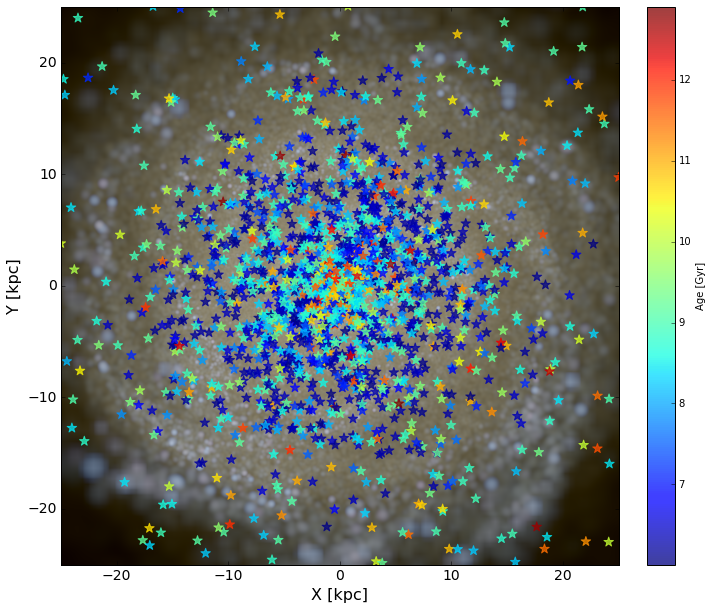

In [17]:
fig, ax1 = plt.subplots(figsize=(10,10))

mask1 = (main.s['NumberOfClusters']>0) * (main.s['age'].in_units('Gyr') > 6)# * (np.abs(main.s['z'])<2)
with pynbody.analysis.faceon(h[0]):
    pynbody.plot.stars.render(main,width=60,resolution=1000, mag_range=[18, 30], axes=ax1, dynamic_range=4, clear=False)
sc = ax1.scatter(main.s['pos'][mask1,0], main.s['pos'][mask1,1], marker = '*', c=main.s['age'].in_units('Gyr')[mask1], edgecolors='face', s=100, alpha=0.75)
ax1.set(xlim=(-25,25), ylim=(-25,25))
# ax1.text(10,25,r'z=0, $\tau_{\rm{cl}} < 500$ Myr', fontsize=16, color='w')
ax1.tick_params(axis='both', which='both', labelsize=14)
ax1.set_xlabel('X [kpc]', fontsize=16)
ax1.set_ylabel('Y [kpc]', fontsize=16)
plt.colorbar(sc, label='Age [Gyr]', cax=ax1.inset_axes([1.05, 0., 0.05, 1.]))

# ax2 = plt.axes([0,0,1,1])
# ip = InsetPosition(ax1, [0.5, 0.03, 0.48, 0.48])
# ax2.set_axes_locator(ip)
# mark_inset( ax1, ax2, loc1=1, loc2=3, fc="none", ec="w")
# pynbody.plot.stars.render(main,width=6,resolution=1000, mag_range=[18, 25], axes=ax2, dynamic_range=4, clear=False)
# mask2 = (main.s['NumberOfClusters']>0) * (main.s['age'].in_units('Gyr') < 0.1) * (np.abs(main.s['pos'][:,0])<4) * (np.abs(main.s['pos'][:,1])<4)# * (np.abs(main.s['z'])<2)
# ax2.scatter(main.s['pos'][mask2,0], main.s['pos'][mask2,1], marker = 'o', facecolor='none', edgecolors='m', s=300)
# ax2.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
# for spine in ax2.spines.values():
#     spine.set_edgecolor('w')
# ax2.set(xlabel='', ylabel='', xlim=(-3,3), ylim=(-3,3))

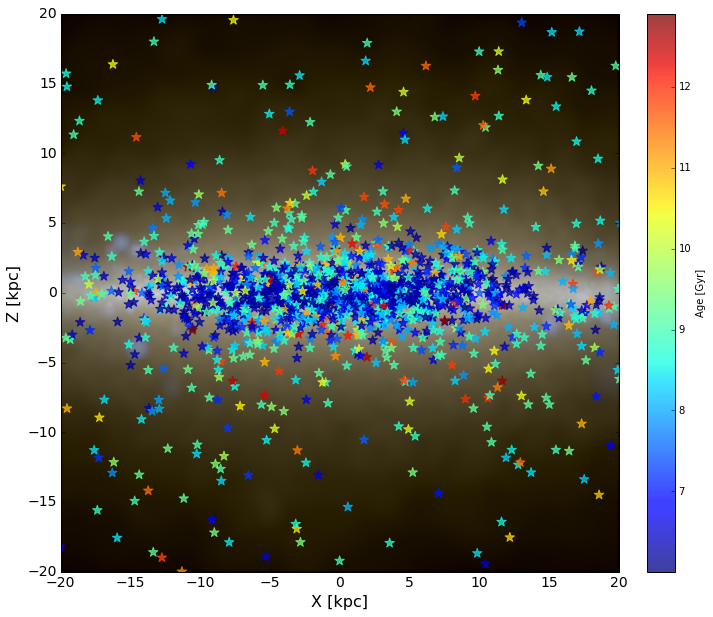

In [19]:
fig, ax1 = plt.subplots(figsize=(10,10))

with pynbody.analysis.sideon(h[0]):
    pynbody.plot.stars.render(main,width=40,resolution=1000, mag_range=[18, 30], axes=ax1, dynamic_range=4, clear=False)
sc = ax1.scatter(main.s['pos'][mask1,1], main.s['pos'][mask1,2], marker = '*', c=main.s['age'].in_units('Gyr')[mask1], edgecolors='face', s=100, alpha=0.75)
ax1.set(xlim=(-20,20), ylim=(-20,20))
# ax1.text(10,25,r'z=0, $\tau_{\rm{cl}} < 500$ Myr', fontsize=16, color='w')
ax1.tick_params(axis='both', which='both', labelsize=14)
ax1.set_xlabel('X [kpc]', fontsize=16)
ax1.set_ylabel('Z [kpc]', fontsize=16)
plt.colorbar(sc, label='Age [Gyr]', cax=ax1.inset_axes([1.05, 0., 0.05, 1.]))
# plt.tight_layout()